# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)

# HW3: REINFORCE with and without baseline in CartPole
> - Full Name: **[Full Name]**
> - Student ID: **[Stundet ID]**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **CartPole-v1** environment. It also compares the performance of **REINFORCE with and without a baseline** to assess its impact on training stability and efficiency.  

**Grading Breakdown:**

- Practical Implementation: 70 points
- Conceptual Understanding: 30 points

# Setup

All required packages are pre-installed if using Google Colab.


Import the following libraries.

In [1]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib
import matplotlib.pyplot as plt
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [2]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [3]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action = torch.argmax(policy_net(state_tensor)).item()
                state, _, terminated, truncated, _ = env.step(action)

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment  (5 points)

Initialize CartPole Environment and Display State & Action Spaces

In [4]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


**Question 1: (5 points)**

How are the observation and action spaces defined in the CartPole environment?

The observation space in CartPole-v1 consists of a continuous 4-dimensional vector representing:

Cart position

Cart velocity

Pole angle

Pole angular velocity

The action space is discrete, meaning there are only two possible actions:

0: Move the cart to the left

1: Move the cart to the right


Define a Random Policy for Action Selection  

In [5]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values = torch.rand(self.action_space_n)
        return action_values

Visualize the random policy.

In [6]:
random_policy = RandomPolicy(env.action_space.n)

record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), random_policy, "Video_CartPole_random_policy")

# Agent with REINFORCE: Baseline vs. No Baseline in CartPole-v1 (85 points)


### Policy Network Definition (5 points)

To define a neural network that represents the agent’s policy for selecting actions.

The policy network takes the environment’s state as input and outputs a probability distribution over possible actions.

In [7]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.output_layer(x))
        return action_probs


### Computing Discounted Returns (10 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [8]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0  # Initialize return
    for reward in reversed(rewards):  # Process rewards from end to start
        G = reward + gamma * G  # Discounted sum of future rewards
        returns.insert(0, G)  # Insert at the beginning
    return returns


**Question 2: (5 points)**

What is the role of the discount factor (𝛾) in reinforcement learning, and what happens when 𝛾=0 or 𝛾=1?

.....</br>
The discount factor 𝛾 determines how future rewards contribute to the current value estimation.

When 𝛾 = 1: The agent considers all future rewards equally, leading to long-term planning.

When 𝛾 = 0: The agent only values immediate rewards, effectively making it a greedy strategy.

Typical range: 0 < 𝛾 < 1 ensures that future rewards have a diminishing impact, balancing short-term and long-term rewards.
.....</br>


### Implementing the REINFORCE Algorithm (Without Baseline) (20 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [9]:
def reinforce(env, policy_net, optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []

    for episode in range(num_episodes):
        log_probs = []
        rewards = []

        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).to(DEVICE)

            action_probs = policy_net(state_tensor)
            distribution = Categorical(action_probs)
            action = distribution.sample()

            log_probs.append(distribution.log_prob(action))
            step_result = env.step(action.item())

            if len(step_result) == 4:  # Gym v26+
                next_state, reward, done, info = step_result
                terminated, truncated = done, False  # Treat `done` as `terminated`
            else:  # Older Gym versions
                next_state, reward, terminated, truncated, info = step_result

            rewards.append(reward)
            done = terminated or truncated
            state = next_state
        # Compute discounted returns
        returns = compute_returns(rewards, gamma)

        # Compute policy loss
        policy_loss = [-log_prob * Gt for log_prob, Gt in zip(log_probs, returns)]

        optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        optimizer.step()

        rewards_per_episode.append(sum(rewards))

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {sum(rewards)}")

    return rewards_per_episode


### Value Network Definition (Baseline Network) (5 points)

Defines a neural network that approximates the value function, which estimates the expected return from a given state. The network takes the environment’s state as input and outputs a scalar value, representing the long-term reward the agent can expect from that state.

In [10]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)  # Outputs a scalar value

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.output_layer(x)  # No activation since it's a scalar
        return value

### Implementing REINFORCE with a Baseline (20 points)

To reduce variance in policy updates, we introduce a **baseline** function $( V(s) )$, which estimates the expected return from a given state. Instead of using the full return $( G_t )$, we adjust the policy update by incorporating the baseline:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) (G_t - V(s_t))
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

  $$[
  G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
  ]$$

- $( V(s_t) )$ is the **baseline function**, estimated by a **value network**, which is trained using mean squared error (MSE) between predicted values and actual returns:  

  $$[
  L = \frac{1}{N} \sum_{t=0}^{N} (G_t - V(s_t))^2
  ]$$

The introduction of the baseline does not change the expected value of the gradient but significantly **reduces variance**, leading to more stable learning.  


In [11]:
def reinforce_with_baseline(env, policy_net, baseline_net, policy_optimizer, baseline_optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []

    for episode in range(num_episodes):
        log_probs = []
        rewards = []
        values = []

        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).to(DEVICE)
            action_probs = policy_net(state_tensor)
            value = baseline_net(state_tensor)

            distribution = Categorical(action_probs)
            action = distribution.sample()

            log_probs.append(distribution.log_prob(action))
            values.append(value)

            step_result = env.step(action.item())
            if len(step_result) == 4:  # Gym v26+
                next_state, reward, done, info = step_result
                terminated, truncated = done, False  # Treat `done` as `terminated`
            else:  # Older Gym versions
                next_state, reward, terminated, truncated, info = step_result

            rewards.append(reward)
            done = terminated or truncated
            state = next_state

        # Compute discounted returns
        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32).to(DEVICE)

        values = torch.cat(values)
        advantages = returns - values.detach()  # Compute advantage

        # Compute policy loss
        policy_loss = (-torch.stack(log_probs) * advantages).sum()

        # Compute baseline loss (MSE loss)
        baseline_loss = nn.MSELoss()(values, returns)

        # Update policy network
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Update value network
        baseline_optimizer.zero_grad()
        baseline_loss.backward()
        baseline_optimizer.step()

        rewards_per_episode.append(sum(rewards))

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {sum(rewards)}")

    return rewards_per_episode

**Question 3: (5 points)**

Why is a baseline introduced in the REINFORCE algorithm, and how does it contribute to training stability?

.....</br>
A baseline (typically a value function) is introduced to reduce variance in policy gradient updates without introducing bias. The advantage function A(s_t,a_t)=G_t−V(s_t) helps the agent determine whether an action is better or worse than the expected return from that state. This leads to:

More stable training (reducing high variance in updates).
Faster convergence since updates are less noisy.
Better performance as the policy optimization is more structured.

.....</br>


### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [12]:
# TODO: Define all necessary hyperparameters
INPUT_DIM = env.observation_space.shape[0]
OUTPUT_DIM = env.action_space.n
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 4000

# Initialize Policy and Baseline Networks
policy_net_no_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
policy_net_with_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
baseline_net = ValueNetwork(INPUT_DIM).to(DEVICE)

# Optimizers
policy_optimizer_no_baseline = optim.Adam(policy_net_no_baseline.parameters(), lr=LEARNING_RATE)
policy_optimizer_with_baseline = optim.Adam(policy_net_with_baseline.parameters(), lr=LEARNING_RATE)
baseline_optimizer = optim.Adam(baseline_net.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE without Baseline:")
rewards_no_baseline = reinforce(env, policy_net_no_baseline, policy_optimizer_no_baseline, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

print("\n--------------------------------------------------------------------\n")

print("Training REINFORCE with Baseline:")
rewards_with_baseline = reinforce_with_baseline(
    env, policy_net_with_baseline, baseline_net, policy_optimizer_with_baseline, baseline_optimizer,
    num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR
)

Training REINFORCE without Baseline:
Episode 50, Reward: 27.0
Episode 100, Reward: 102.0
Episode 150, Reward: 25.0
Episode 200, Reward: 198.0
Episode 250, Reward: 235.0
Episode 300, Reward: 52.0
Episode 350, Reward: 105.0
Episode 400, Reward: 500.0
Episode 450, Reward: 115.0
Episode 500, Reward: 116.0
Episode 550, Reward: 489.0
Episode 600, Reward: 500.0
Episode 650, Reward: 165.0
Episode 700, Reward: 342.0
Episode 750, Reward: 321.0
Episode 800, Reward: 188.0
Episode 850, Reward: 500.0
Episode 900, Reward: 500.0
Episode 950, Reward: 500.0
Episode 1000, Reward: 500.0
Episode 1050, Reward: 500.0
Episode 1100, Reward: 220.0
Episode 1150, Reward: 500.0
Episode 1200, Reward: 241.0
Episode 1250, Reward: 105.0
Episode 1300, Reward: 138.0
Episode 1350, Reward: 500.0
Episode 1400, Reward: 367.0
Episode 1450, Reward: 500.0
Episode 1500, Reward: 25.0
Episode 1550, Reward: 157.0
Episode 1600, Reward: 177.0
Episode 1650, Reward: 500.0
Episode 1700, Reward: 308.0
Episode 1750, Reward: 256.0
Episode

**Question 4: (5 points)**

What are the primary challenges associated with policy gradient methods like REINFORCE?

.....</br>
High Variance

Policy gradients often have high variance, leading to unstable learning and slow convergence.
Sample Inefficiency

REINFORCE discards episode data after each update, making it less data-efficient than methods like Q-learning or PPO.
Delayed Updates

Unlike Q-learning, which updates per step, REINFORCE updates parameters only after full episodes, leading to slower learning.
Credit Assignment Problem

Assigning credit to specific actions over long trajectories is challenging since updates are made at the end of episodes.
Lack of Off-Policy Learning

REINFORCE is an on-policy algorithm, meaning it cannot reuse past experiences to improve efficiency, unlike off-policy methods like DQN.
.....</br>


# Plot and Comparing Results (10 points)

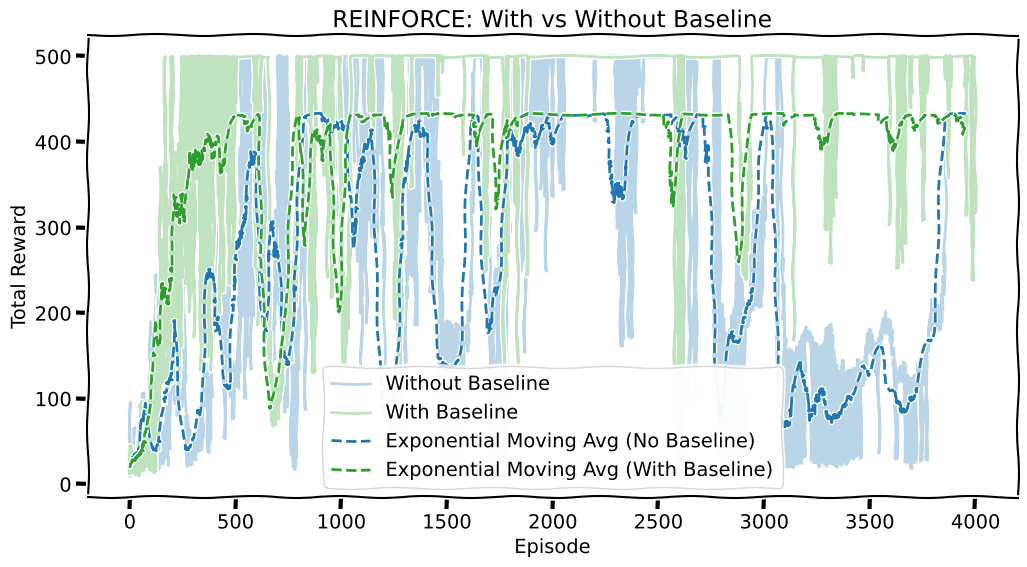

In [13]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards_no_baseline, label="Without Baseline", alpha=0.3, color='tab:blue')
plt.plot(rewards_with_baseline, label="With Baseline", alpha=0.3, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards_no_baseline, window_size), label="Exponential Moving Avg (No Baseline)", linestyle='--', color='tab:blue')
plt.plot(exponential_moving_average(rewards_with_baseline, window_size), label="Exponential Moving Avg (With Baseline)", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: With vs Without Baseline")
plt.show()

In [14]:
mean_reward, std_reward = np.mean(rewards_no_baseline), np.std(rewards_no_baseline)
print(f"No Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward, std_reward = np.mean(rewards_with_baseline), np.std(rewards_with_baseline)
print(f"With Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

No Baseline: mean_reward = 305.19 +/- 178.7826
With Baseline: mean_reward = 448.00 +/- 121.9883


**Question 5:** (5 points)

Based on the results, how does REINFORCE with a baseline compare to REINFORCE without a baseline in terms of performance?

.....</br>
.....</br>


**Question 6:** (5 points)

Explain how variance affects policy gradient methods, particularly in the context of estimating gradients from sampled trajectories.

.....</br>
.....</br>

# Simulation

In [15]:
# Record the simulation using the optimal policy no baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_no_baseline, "Video_CartPole_no_baseline")

In [16]:
# Record the simulation using the optimal policy with baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_with_baseline, "Video_CartPole_with_baseline")